# Training a ViT from scratch on smaller datasets with shifted patch tokenization and locality self-attention

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 29/06/2024
<br>
**Reference:**
- [Vision Transformer for Small-Size Datasets](
https://doi.org/10.48550/arXiv.2112.13492)

- [Keras](https://keras.io/examples/vision/vit_small_ds/)

## Introduction

In the paper ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](
https://doi.org/10.48550/arXiv.2010.11929
), the authors highlight the data-intensive nature of Vision Transformers (ViT). To outperform state-of-the-art Convolutional Neural Network (CNN) models, ViTs must be pretrained on large datasets like JFT300M and subsequently fine-tuned on medium-sized datasets such as ImageNet.

ViTs require more data primarily because their self-attention layer lacks locality inductive bias. This bias refers to the concept that image pixels are locally correlated and their correlation maps are translation-invariant. In contrast, CNNs use spatial sliding windows to analyze images, enabling them to achieve better results with smaller datasets.
[Vision Transformer for Small-Size Datasets](
https://doi.org/10.48550/arXiv.2112.13492) aims to address the lack of locality inductive bias in ViTs. The authors propose two main ideas to enhance ViT performance on smaller datasets:

- **Shifted Patch Tokenization**
- **Locality Self Attention**

This example implements the concepts from the paper, with significant inspiration drawn from the "Image classification with Vision Transformer" model.

## Imports

In [ ]:
! pip install --upgrade keras

In [ ]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)

## Prepare the data

In [ ]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f'x_train shape: {x_train.shape} - y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape} - y_test shape: {y_test.shape}')

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0

# TRAINING
EPOCHS = 10 #50

# ARCHITECTIRE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name='data_augmentation',
)

# Compute the mean and the variace of the training data for normalization
data_augmentation.layers[0].adapt(x_train)

## Implement Shifted Patch Tokenization (STP) for Vision Transformers

Shifted Patch Tokenization (STP) is designed to address the low receptive field of Vision Transformers (ViTs) by incorporating more local context into the tokens. Here's a detailed explanation of the steps involved in STP:

1. **Start with an Image:**
   - Begin with the original input image.

2. **Shift the Image in Diagonal Directions:**
   - Create several versions of the image by shifting it in different diagonal directions (e.g., top-left, top-right, bottom-left, bottom-right).

3. **Concat the Diagonally Shifted Images with the Original Image:**
   - Concatenate the diagonally shifted images with the original image to form a larger composite image.

4. **Extract Patches of the Concatenated Images:**
   - From the composite image, extract patches. This step ensures that each patch now contains more local context due to the inclusion of shifted versions of the original image.

5. **Flatten the Spatial Dimension of All Patches:**
   - Flatten the spatial dimensions of each patch to convert them into a 1D sequence. This step prepares the patches for input into the transformer model.

6. **Layer Normalize the Flattened Patches and then Project Them:**
   - Apply layer normalization to the flattened patches to stabilize training and improve convergence.
   - Linearly project the normalized patches to the desired token dimension. This step converts the patches into tokens that can be processed by the transformer model.


![](https://i.imgur.com/bUnHxd0.png)

In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

### Visualize the patches

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


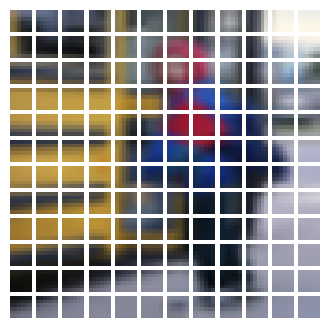

ORIGINAL


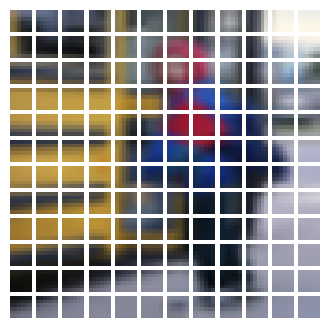

LEFT-UP


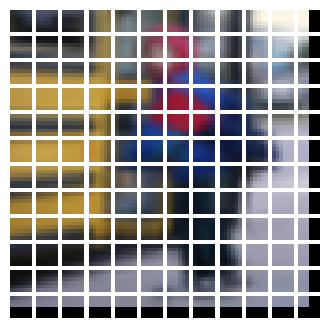

LEFT-DOWN


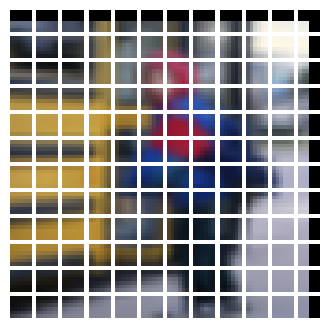

RIGHT-UP


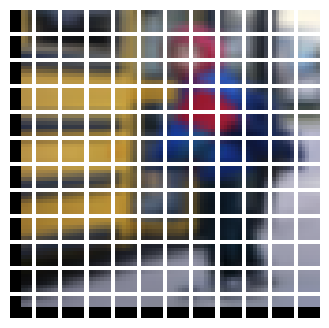

RIGHT-DOWN


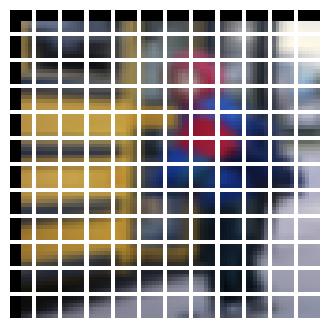

In [ ]:
# Get a random image from the training dataset and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]),
    size=(IMAGE_SIZE, IMAGE_SIZE),
)

# Vanilla patch maker: This takes an image and divides into patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
  for col in range(n):
    plt.subplot(n, n, count)
    count = count + 1
    image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(image)
    plt.axis('off')
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it diagonlly and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()


## Implement the patch encoding layer

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(
      self,
      num_patches=NUM_PATCHES,
      projection_dim=PROJECTION_DIM,
      **kwargs,
  ):
      super().__init__(**kwargs)
      self.num_patches = num_patches
      self.position_embedding = layers.Embedding(
          input_dim=num_patches, output_dim=projection_dim
      )
      self.positions = tf.range(start=0, limit=num_patches, delta=1)

  def call(self, encoded_patches):
    encoded_positions = self.position_embedding(self.positions)
    encoded_patches = encoded_patches + encoded_positions
    return encoded_patches

### Implementation of Locality Self Attention (LSA)

Locality Self Attention (LSA) enhances the regular attention mechanism by addressing the limitations of self-attention, specifically its tendency to prioritize self-token relations over inter-token relations. This adjustment is critical for Vision Transformers (ViTs) dealing with small-sized datasets, as it ensures more balanced and meaningful attention across tokens.

### Regular Attention Mechanism

The regular attention mechanism can be summarized as follows:

1. **Input Components:**
   - **Query (Q), Key (K), and Value (V)** are derived from the input.
   - In self-attention, Q, K, and V are identical.

2. **Compute Similarity:**
   - Compute the dot product of the query and key: \( QK^T \).
   - Scale the result by the square root of the key dimension: \( QK^T \) /\( sqrt(d_k) ).

![](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png)

3. **Apply Softmax:**
   - Apply the softmax function to the scaled dot product to obtain attention weights.
   - Softmax ensures the weights sum to 1, highlighting the most relevant tokens.

4. **Modulate Values:**
   - Multiply the attention weights by the value to get the final output.

### Enhancements in Locality Self Attention

1. **Diagonal Masking:**
   - Mask the diagonal of the dot product to prevent self-attention from prioritizing self-token relations.
   - This enforces the model to focus on inter-token relationships.

2. **Learnable Temperature Term:**
   - Introduce a trainable scaling factor (temperature) instead of a fixed constant.
   - This allows dynamic modulation of the softmax function based on the data.

![](https://i.imgur.com/GTV99pk.png)

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

## Implement the MLP

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [ ]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## Compile, train, and evaluate the mode

In [ ]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
      self,
      learning_rate_base,
      total_steps,
      warmup_learning_rate,
      warmup_steps
  ):
    super().__init__()

    self.learning_rate_base = learning_rate_base
    self.total_steps = total_steps
    self.warmup_learning_rate = warmup_learning_rate
    self.warmup_steps = warmup_steps
    self.pi = tf.constant(np.pi)

  def __call__(self, step):
    if self.total_steps < self.warmup_steps:
      raise ValueError('Tatal_steps must be larger or equal to warmup_steps')

    cos_annealed_lr = tf.cos(
        self.pi
        * (tf.cast(step, tf.float32) - self.warmup_steps)
        / float(self.total_steps - self.warmup_steps)
    )
    learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

    if self.warmup_steps > 0:
      if self.learning_rate_base < self.warmup_learning_rate:
        raise ValueError(
            'Learning_rate_base must be larger or equal to "warmup_learning_rate".'
        )
      slope = (
          self.learning_rate_base - self.warmup_learning_rate
      ) / self.warmup_steps
      warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
      learning_rate = tf.where(
          step < self.warmup_steps, warmup_rate, learning_rate
      )
    return tf.where(
        step > self.total_steps, 0.0, learning_rate, name='learning_rate'
    )

def run_experiment(model):
  total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
  warmup_epoch_percentage = 0.10
  warmup_steps = int(total_steps * warmup_epoch_percentage)
  scheduled_lrs = WarmUpCosine(
      learning_rate_base=LEARNING_RATE,
      total_steps=total_steps,
      warmup_learning_rate=0.0,
      warmup_steps=warmup_steps,
  )

  optimizer = keras.optimizers.AdamW(
      learning_rate=LEARNING_RATE,
      weight_decay=WEIGHT_DECAY
      )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
          keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
      ],
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_split=0.1,
  )

  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
  print(f'Test accuracy: {round(accuracy * 100, 2)}%')
  print(f'Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%')

  return history

# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'shifted_patch_tokenization_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3339s 19s/step - accuracy: 0.0270 - loss: 4.9333 - top-5-accuracy: 0.1074 - val_accuracy: 0.1052 - val_loss: 3.9455 - val_top-5-accuracy: 0.3014
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 3278s 19s/step - accuracy: 0.0777 - loss: 4.0766 - top-5-accuracy: 0.2493 - val_accuracy: 0.1458 - val_loss: 3.6300 - val_top-5-accuracy: 0.4026
Epoch 3/10
 34/176 ━━━━━━━━━━━━━━━━━━━━ 40:08 17s/step - accuracy: 0.1084 - loss: 3.8850 - top-5-accuracy: 0.3052